Este projeto tem por objetivo  aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB.

O foco é que a partir de um banco de dados qualquer que contenha 2 classes, utilizando as redes neurais já existentes do imagenet, possamos realizar a transferência de aprendizagem.

- (English Translate)

This project aims to apply the Transfer Learning method to a Deep Learning network using the Python language in the COLAB environment.

The focus is to enable, starting from any dataset containing two classes, the use of pre-trained neural networks from ImageNet to perform transfer learning.


O primeiro passo é importar as bibliotecas que serão utilizadas ao longo do código


- (English Translate)


The first step is to import the libraries that will be used throughout the code.

In [ ]:
# Bibliotecas
import os
import pandas as pd
import glob

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import numpy as np


# Importando VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

  O dataset escolhido é uma série de tipos de instrumentos musicais.
  O dataset foi obtido do através do link: https://data.mendeley.com/datasets/pk7txkgt4v/2?utm_source


  O mesmo foi adicionado ao meu google drive e de lá consegui trazer para o código. No Google Drive foi criado uma pasta chamada "Datasets" e dentro dessa pasta uma outra pasta chamada de "instrumentos" onde será o repositórios das pastas: "treino", "teste" e "validacao"


Obs.: O dataset é comporto por 21 tipos de instrumentos (categorias).
      Para efeito de otimizar processamento e tempo utilizarei apenas 2 categorias "Cavaquinho" e "Flauta". As mesmas foram escolhidas de forma arbitrária, ou seja, poderia ter escolhido qualquer outra categoria.


- (English Translate)

The selected dataset consists of a collection of different types of musical instruments. The dataset was obtained from the following link: https://data.mendeley.com/datasets/pk7txkgt4v/2?utm_source

It was added to my Google Drive, from where it was imported into the code. In Google Drive, a folder named “Datasets” was created, and inside it another folder named “instrumentos”, which contains the directories "treino", "teste" and "validacao".

Note: The dataset is composed of 21 types of instruments (categories).
      For optimization, processing efficiency, and time considerations, only two categories—“Cavaquinho” and “Flute”—were used. These categories were chosen arbitrarily, meaning that any other categories could have been selected.

Precisamos que ter acesso ao drive, já que estamos usano o Google Colab

- (English Translate)

We need to access the drive, since we are using Google Colab.

In [ ]:
# Acesso ao Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Especificando o caminho do diretório onde as imagens estão armazenadas e suas respectivas pastas

- (English Translate)

Specifying the path to the directory where the images are stored and their respective folders.

In [ ]:
# Diretórios dos dados
BASE_PATH = "/content/drive/MyDrive/Datasets/instrumentos"
SPLITS = ["treino", "validacao", "teste"]

Função que realiza o filtro das categorias desejadas do dataset "Cavaquinho", "Flauta".

Lembrando que possuímos 21 categorias e estamos analisando apenas 2 delas.

- (English Translate)

Function that filters the desired categories from the dataset: “Cavaquinho” and “Flute”.

It is worth noting that the dataset contains 21 categories, and we are analyzing only two of them.

In [ ]:

# Função para extrair categorias de uma pasta, ignorando "Palheta"


def get_categories(path):
    ALLOWED_CATEGORIES = {"cavaquinho", "flauta"}

    files = [
        f for f in os.listdir(path)
        if os.path.isfile(os.path.join(path, f))
    ]

    categories = []
    for f in files:
        parts = f.split("_")
        if len(parts) < 2:
            continue  # pula arquivos sem "_"
        category = parts[0].lower()  # pega a primeira parte do nome
        if category in ALLOWED_CATEGORIES:
            categories.append(category)

    # Remove duplicados e ordena
    categories = sorted(set(categories))
    return categories

# Percorrendo todas as pastas
all_categories = {}
for split in SPLITS:
    split_path = os.path.join(BASE_PATH, split)

    if not os.path.exists(split_path):
        print(f"⚠️ Pasta {split} não encontrada")
        continue

    categories = get_categories(split_path)
    all_categories[split] = categories

    print(f"\n📂 {split.upper()}")
    for c in categories:
        print(" ├──", c)
    print("Total de categorias:", len(categories))


📂 TREINO
 ├── cavaquinho
 ├── flauta
Total de categorias: 2

📂 VALIDACAO
 ├── cavaquinho
 ├── flauta
Total de categorias: 2

📂 TESTE
 ├── cavaquinho
 ├── flauta
Total de categorias: 2


Definindo o parâmetro para as imagens do treinamento, ou seja:

IMG_SIZE = Tamanho de cada imagem do dataset.

BATCH_SIZE = Quantidade de imagens processadas de uma vez durante o treino

- (English Translate)


Defining the parameters for the training images, namely:

IMG_SIZE = the size of each image in the dataset.

BATCH_SIZE = the number of images processed at once during training.

In [ ]:
# Parâmetros do treinamento
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

Criando um dataframe com as categorias das imagens de cada pasta  "treino", "teste" and "validacao".

Logo, cada pasta terá uma tabela com o mesmo tamanho (quantidade de imagens) e mesmas cateforias determinadas acima.

- (English Translate)

Creating a DataFrame with the image categories for each folder: “training”, “testing”, and “validation”.

Thus, each folder will have a table with the same size (number of images) and the same categories defined above.

In [ ]:
# Função para criar DataFrame a partir de arquivos e categorias,

ALLOWED_CLASSES = ["cavaquinho", "flauta"]  # suas classes
IMG_EXTENSIONS = (".jpg", ".jpeg", ".png")

def create_dataframe_with_path(folder_path):
    files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith(IMG_EXTENSIONS)
    ]
    # Extrai a classe pelo prefixo do nome do arquivo
    classes = [f.split("_")[0].lower() for f in files]

    # Filtra apenas classes permitidas
    data = [(os.path.join(folder_path, f), c) for f, c in zip(files, classes) if c in ALLOWED_CLASSES]

    df = pd.DataFrame(data, columns=["filepath", "class"])
    return df

# Criando DataFrames com caminho completo
df_train = create_dataframe_with_path(os.path.join(BASE_PATH, "treino"))
df_valid = create_dataframe_with_path(os.path.join(BASE_PATH, "validacao"))
df_test  = create_dataframe_with_path(os.path.join(BASE_PATH, "teste"))

# Conferindo
print("Treino:", len(df_train))
print("Validação:", len(df_valid))
print("Teste:", len(df_test))
df_train.head()


Treino: 80
Validação: 80
Teste: 80


,filepath,class
0,/content/drive/MyDrive/Datasets/instrumentos/t...,cavaquinho
1,/content/drive/MyDrive/Datasets/instrumentos/t...,cavaquinho
2,/content/drive/MyDrive/Datasets/instrumentos/t...,cavaquinho
3,/content/drive/MyDrive/Datasets/instrumentos/t...,cavaquinho
4,/content/drive/MyDrive/Datasets/instrumentos/t...,cavaquinho


Realizando o pré-processamento das imagens do dataset "ImageData".

A função abaixo é responsável por:

- Normalziar os pixels de valores de (0 - 255) para valores de (0 - 1);
- Rotacionar a imagem de -10º 0 10º (muito importante para procesamento de imagens pois a partir de uma úncia imagem podemos ter diferentes óticas que ajudam na aprendizagem da máquina);
- Ampliação da imagem com limite de 0.1;
- Espelhar a imagem horizontalmente.

- (English Translate)


Performing the preprocessing of the images from the ImageData dataset.

The function below is responsible for:

- Normalizing pixel values from the range 0–255 to 0–1;

- Rotating the image by –10° to 10° (this is very important in image processing, as from a single image we can obtain different perspectives that help improve the model’s learning);

- Applying image zoom with a limit of 0.1;

- Flipping the image horizontally.

In [ ]:
# Geradores de dados
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

valid_gen = ImageDataGenerator(rescale=1./255)
test_gen  = ImageDataGenerator(rescale=1./255)


- Lê caminhos de imagens a partir do DataFrame criado

- Carrega as imagens do disco

- Aplica de pré-processamento / aumento de dados

- Gera lotes prontos para o modelo treinar, validar ou testar


- (English Translate)


- Reads image paths from the created DataFrame

- Loads images from disk

- Applies preprocessing / data augmentation

- Generates batches ready for model training, validation, or testing

In [ ]:
# Assim como foi realizado na categoria nos dados de treino deve ter a mesma quantidade de categoria, por isso, foi realizado o filtro.
train_data = train_gen.flow_from_dataframe(
    dataframe=df_train,
    x_col="filepath",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=ALLOWED_CLASSES
)

valid_data = valid_gen.flow_from_dataframe(
    dataframe=df_valid,
    x_col="filepath",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes=ALLOWED_CLASSES
)

test_data = test_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col="filepath",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    classes=ALLOWED_CLASSES
)



Found 80 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.
Found 80 validated image filenames belonging to 2 classes.


- Conta quantas classes distintas existem

- Fornece a ordem das classes

(English Translate)

- Counts how many distinct classes exist

- Provides the order of the classes


In [ ]:
# Garante que todos os nomes das classes fiquem minúsculos
train_data.class_indices = {k.lower(): v for k, v in train_data.class_indices.items()}

NUM_CLASSES = len(train_data.class_indices)
print(NUM_CLASSES)          # deve imprimir 2
print(train_data.class_indices) # deve imprimir o dicionário das classes

2
{'cavaquinho': 0, 'flauta': 1}


Faz a chamada da rede VGG16 e seus devidos parâmetros

(English Translate)

Calls the VGG16 network and its respective parameters

In [ ]:
# Modelo base VGG16 (Carregamento do modelo)
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


A função congela todas as camadas exceto as 2 últimas

Lembrando que ainda estamos falando do treinamento de da rede VGG16

(English Translate)

The function freezes all layers except for the last two

Keeping in mind that we are still discussing the VGG16 network training

In [ ]:
# Congela todas as camadas e libera APENAS as 2 últimas camadas

for layer in base_model.layers[:-2]:
    layer.trainable = False
for layer in base_model.layers[-2:]:
    layer.trainable = True

- Transforma características genéricas em decisão específica

- Cria parte do modelo que realmente aprende o problema

- É o coração do transfer learning

(English Translate)

- Transforms generic features into specific decisions

- Creates the part of the model that actually learns the problem

- It is the heart of transfer learning

In [ ]:
# Cabeça de classificação
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

- O modelo para ser treinado e depois mostra a estrutura completa da rede.

- Ele não treina , apenas define como o treinamento vai acontecer.


(English Translate)


- The model is prepared for training and then displays the network's full architecture

- It does not perform the training itself; it only defines the training configuration

In [ ]:
# Compilação (Parâmetros de compilação com a rede)
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,530 (56.64 MB)

 Trainable params: 2,491,650 (9.50 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

- Configura e executa o treinamento do modelo com Early Stopping .

- Ele faz o modelo parar de treinar automaticamente quando não está mais melhorando, evitando overfitting e desperdício de tempo.

Early Stopping = acompanha uma métrica durante o treino e interrompeu o treinamento quando ela para de melhorar.


(English Translate)


- Sets up and executes model training with Early Stopping

- It automatically stops the training process when it is no longer improving, preventing overfitting and wasting time

- Early Stopping: monitors a specific metric during training and halts the process once it ceases to improve

In [ ]:
# Treinamento dos dados do dataset que pegamos os pesos, ou seja, imagenet

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 193s 88s/step - accuracy: 0.4906 - loss: 0.8024 - val_accuracy: 0.5125 - val_loss: 0.7030
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 107s 41s/step - accuracy: 0.4539 - loss: 0.7418 - val_accuracy: 0.5125 - val_loss: 0.6947
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 136s 57s/step - accuracy: 0.5802 - loss: 0.6844 - val_accuracy: 0.5375 - val_loss: 0.6877
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 135s 61s/step - accuracy: 0.4594 - loss: 0.7106 - val_accuracy: 0.5500 - val_loss: 0.6816
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 105s 42s/step - accuracy: 0.4922 - loss: 0.7721 - val_accuracy: 0.5500 - val_loss: 0.6769
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 151s 44s/step - accuracy: 0.5292 - loss: 0.7516 - val_accuracy: 0.5875 - val_loss: 0.6727
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 107s 48s/step - accuracy: 0.3792 - loss: 0.7561 - val_accuracy: 0.6000 - val_loss: 0.6685
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 109s 48s/step - accuracy: 0.4969 - loss: 0.6998 - val_accuracy: 0.6500 - val_loss:

Gráfico que informa o comportamento da aprendizagem do modelo.

Mostra a Perda por época e também mostra a acurácia por época

(English Translate)

Graph that shows the model's learning behavior

Displays loss per epoch and also displays accuracy per epoch

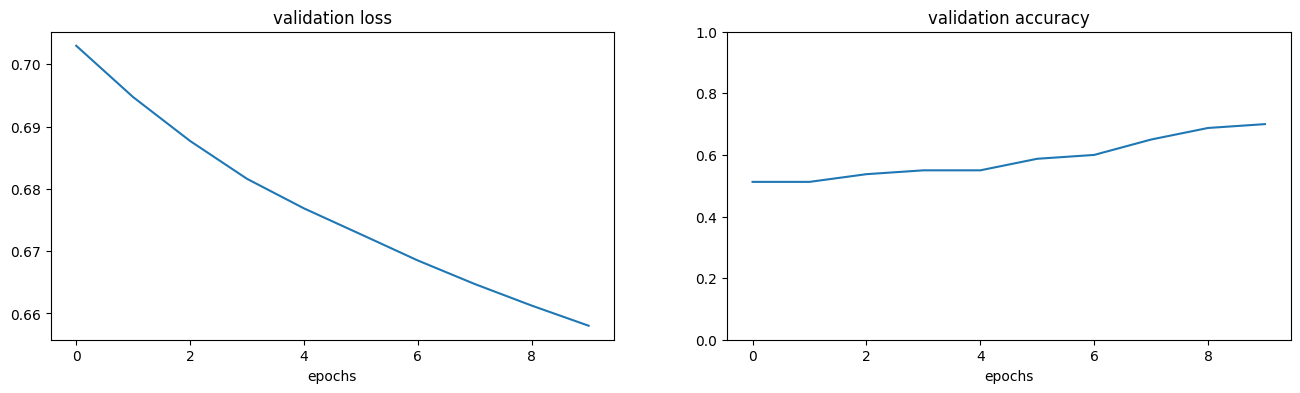

In [ ]:
## Gráfico que informa o comportamento da aprendizagem do modelo
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

- Avalia o desempenho final do modelo usando o conjunto de teste.


- Mede bem o modelo generalizado para dados nunca vistos.


(English Translate)

- Evaluates the final model performance using the test set.

- Measures how well the model generalizes to unseen data.

In [ ]:
# Avaliação no conjunto de teste
test_loss, test_acc = model.evaluate(test_data)
print(f"Teste - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 54s 15s/step - accuracy: 0.7352 - loss: 0.6491
Teste - Loss: 0.6582, Accuracy: 0.7125


- Realiza o ajuste fino (ajuste fino) do modelo

- Descongela apenas as 2 últimas camadas da rede para adaptar os pesos ao meu dataset.

(English Translate)

- Performs the fine-tuning of the model

- Unfreezes only the last 2 layers of the network to adapt the weights to my dataset

In [ ]:
# AQUI OCORRE O AJUSTE PROFUNDO (fine-tuning), ou seja, de treinamento dos meus dados!!!!!

# Congela todas as camadas do backbone
for layer in base_model.layers:
    layer.trainable = False

# Libera APENAS as 2 últimas camadas
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Compilação do modelo
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Treinamento com ajuste fino
history_fine = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 111s 49s/step - accuracy: 0.5771 - loss: 0.6780 - val_accuracy: 0.7125 - val_loss: 0.6542
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 141s 41s/step - accuracy: 0.6383 - loss: 0.6794 - val_accuracy: 0.7375 - val_loss: 0.6506
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 105s 46s/step - accuracy: 0.4729 - loss: 0.7613 - val_accuracy: 0.7375 - val_loss: 0.6472
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 143s 42s/step - accuracy: 0.6365 - loss: 0.6243 - val_accuracy: 0.7500 - val_loss: 0.6441
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 106s 47s/step - accuracy: 0.5813 - loss: 0.7064 - val_accuracy: 0.7250 - val_loss: 0.6412
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 108s 47s/step - accuracy: 0.5146 - loss: 0.7445 - val_accuracy: 0.7250 - val_loss: 0.6381
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 146s 50s/step - accuracy: 0.5083 - loss: 0.7009 - val_accuracy: 0.7250 - val_loss: 0.6350
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 105s 41s/step - accuracy: 0.5688 - loss: 0.6691 - val_accuracy: 0.7375 - val_loss:

Avaliação final do modelo usando o conjunto de teste, ou seja, dados que não foram usados ​​no treinamento nem na validação.

(English Translate)

Final evaluation of the model using the test set—that is, data that was used neither in training nor in validation.

In [ ]:
# Avaliação Final
loss, acc = model.evaluate(test_data)
print("Test loss:", loss)
print("Test accuracy:", acc)


3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 15s/step - accuracy: 0.8922 - loss: 0.6050
Test loss: 0.6181834936141968
Test accuracy: 0.862500011920929


- Plota o gráfico da Perdas do treinamento e teste ao longo das épocas;

- Plota o gráfico da Acurácia do treinamento e teste ao longo das épocas.


(English Translate)


- Plots the training and test Loss graph over the epochs

- Plots the training and test Accuracy graph over the epochs

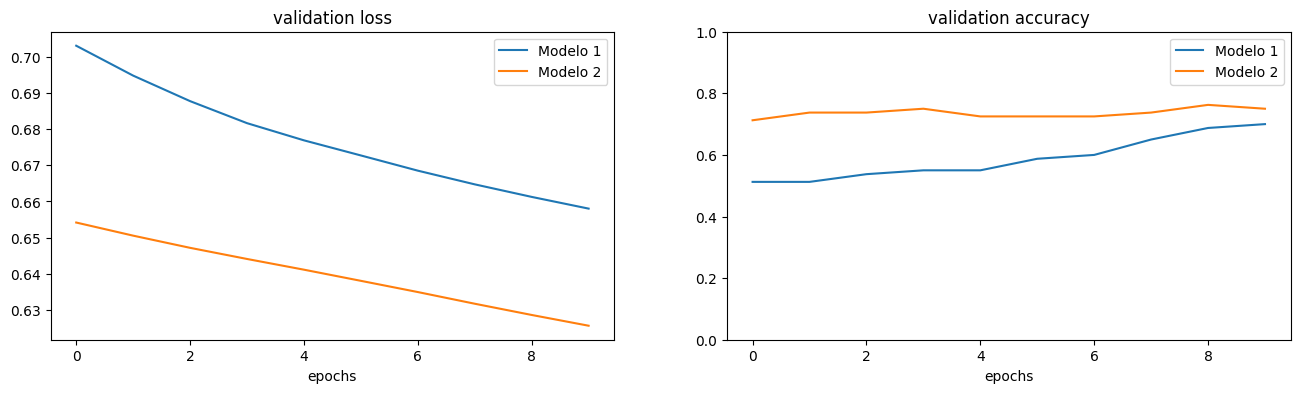

In [ ]:
## Gráfico de comparação da validação do modelo vesus a aprendizagem do dataset

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
'''
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
'''
#Cria como variável
loss1, = ax.plot(history.history["val_loss"])
loss2, = ax.plot(history_fine.history["val_loss"])
loss1.set_label("Modelo 1")
loss2.set_label("Modelo 2")
ax.set_title("validation loss")
ax.set_xlabel("epochs")
ax.legend()

ax2 = fig.add_subplot(122)
'''
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
'''
#Cria como variável
acc1, = ax2.plot(history.history["val_accuracy"])
acc2, = ax2.plot(history_fine.history["val_accuracy"])
acc1.set_label("Modelo 1")
acc2.set_label("Modelo 2")
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)
ax2.legend()

plt.show()

Inserindo o endereço da imagem externa, a foto é categorizada conforme as informações da categorização de entrada.

(English Translate)

By inputting an external image URL, the photo is categorized based on the input categorization data.

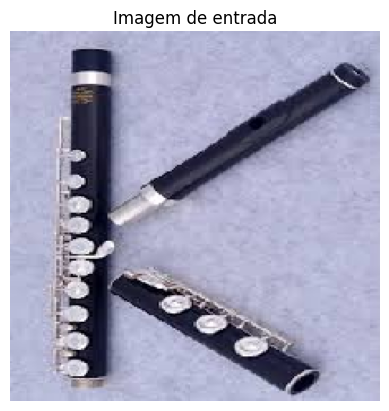

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
Classe prevista: flauta


In [ ]:
# Treino com imagem externa
img_path = "/content/drive/MyDrive/Datasets/DESAFIOS_CODIGOS/TREINAMENTO_RN_TRANSFER_LEARNING/Confronto/flauta008.jpg"  # coloque uma imagem sua

# Carrega e redimensiona a imagem
img = image.load_img(img_path, target_size=IMG_SIZE)
x = image.img_to_array(img) / 255.
x = np.expand_dims(x, axis=0)

# Mostra a imagem
plt.imshow(img)
plt.axis('off')
plt.title("Imagem de entrada")
plt.show()

# Faz a predição
pred = model.predict(x)
class_idx = np.argmax(pred)

# Recupera os nomes das classes
class_labels = list(train_data.class_indices.keys())
print("Classe prevista:", class_labels[class_idx])